<font face="Times New Roman" size=5>
<div dir=rtl align="center">
<font face="Times New Roman" size=5>
In The Name of God
</font>
<br>
<img src="https://logoyar.com/content/wp-content/uploads/2021/04/sharif-university-logo.png" alt="University Logo" width="150" height="150">
<br>
<font face="Times New Roman" size=4 align=center>
Sharif University of Technology - Department of Electrical Engineering
</font>
<br>
<font color="#008080" size=6>
Deep Generative Models
</font>

<hr/>
<font color="#800080" size=5>
Assignment 4: Energy-based Models
<br>
</font>
<font size=5>
Instructor: Dr. S. Amini
<br>
</font>
<font size=4>
Fall 2024
<br>
</font>
<font face="Times New Roman" size=4>
Deadline: Month day at 23:55
</font>
<hr>
</div></font>

This homework helps you implement a Energy-based Model (EBM).  
For references please refer to the original [Implicit Generation and Generalization in Energy-Based Models](https://arxiv.org/abs/1903.08689).

In this homework you need to complete the notebook and run all the cells.
We have specified the parts to be completed with `TODO` tags inside the code blocks.

**NOTES**:
* Feel free to change any part of notebook, but remeber to use comments for clarification.
* You can get **complete score** for this notebook if your codes work properly and without errors.
* This notebook is tested with *Google Colab*.

In [1]:
name = "Amirmahdi Meighnai"
studentId = "400105274"

# Energy-based Models (EBMs) (80 pts)

## Introduction

In this notebook, we will look at energy-based deep learning models, and focus on their application as generative models.

First, let's import our libraries below.

In [2]:
# Standard libraries
import numpy as np
import random

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Subset

# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision.utils import make_grid
from tqdm.notebook import tqdm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

## Energy Models

As we have seen in the class, Energy-based models tend to predict probability density distribution. For this purpose we need to learn given probability:



$p_{\theta }( x_{train}) =\frac{e^{f_{\theta }( x)}}{Z( \theta )}$



Here $p_{\theta }( x_{train})$ stands for probability density of our training data distribution. We know that calculating the partition function ($Z( \theta )$) is interactable. For this purpose we will use contrastive divergence algorithm.

### Contrastive Divergence

We train generative models usually by maximum likelihood estimation. But the exact likelihood of a point cannot be determined due to intractable normalization constant $Z(\theta)$, we need to train energy-based models slightly different. We can re-write our maximum likelihood objective where we maximize the probability of $\mathbf{x}_{\text{train}}$ compared to a randomly sampled data point of our model:

$$
\begin{split}
    \nabla_{\theta}\mathcal{L}_{\text{MLE}}(\mathbf{\theta}) & = \nabla_{\theta}\log p_{\theta}(\mathbf{x})\\[5pt]
    & \approx  \nabla_{\theta}F_{\theta}(\mathbf{x_{\text{train}}}) - \nabla_{\theta}F_{\theta}(\mathbf{x_{\text{sample}}})
\end{split}
$$

Note that the loss is still an objective we want to minimize. Thus, we try to minimize the energy for data points from the dataset, while maximizing the energy for randomly sampled data points from our model. The trick for sampling is that we approximate $Z(\theta)$ by a single Monte-Carlo sample. This gives us the exact same objective as written above.

Visually, the objective is shown below (figure - [Stefano Ermon and Aditya Grover](https://deepgenerativemodels.github.io/assets/slides/cs236_lecture11.pdf)):


<center width="100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/contrastive_divergence.svg" width="90%"></center>


The point on the right, called "correct answer", represents a data point from the dataset (i.e. $x_{\text{train}}$), and the left point, "wrong answer", a sample from our model (i.e. $x_{\text{sample}}$). Thus, we try to "pull up" the probability of the data points in the dataset, while "pushing down" randomly sampled points.

### Dataset

First, we load the MNIST dataset below. Note that we need to normalize the images between -1 and 1 instead of mean 0 and std 1 because during sampling, we have to limit the input space. Scaling between -1 and 1 makes it easier to implement it.

In [3]:
############ TODO #############:
BATCH_SIZE = 256

transform = transforms.Compose([
    transforms.ToTensor(),                  # Convert PIL image to tensor
    transforms.Normalize((0.5,), (0.5,))   # Normalize to [-1, 1]: (x - 0.5) / 0.5
])
###############################

train_set = MNIST(root='./', train=True, transform=transform, download=True)
test_set = MNIST(root='./', train=False, transform=transform, download=True)

train_size = len(train_set)
subset_size = int(train_size * 1)  # 1000% of the data
subset_indices = torch.randperm(train_size).tolist()[:subset_size]

train_subset = Subset(train_set, subset_indices)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True,  drop_last=True, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

### CNN Model

First, we implement our CNN model. The MNIST images are 28x28, hence a small model is enough. But you are free to use pre-trained Convolution Networks (such as Resnet, etc.)

Here we use a smooth activation function like Swish instead of ReLU in the energy model. This is because gradients should not be sparse.

In [4]:
class Swish(nn.Module):

    def forward(self, x):
        return x * torch.sigmoid(x)

class CNNModel(nn.Module):

    def __init__(self, hidden_features=32, out_dim=1):
        super(CNNModel, self).__init__()
        ############ TODO #############:
        # Define hidden layers (Conv) in and out dimensions
        hidden_dim1 = hidden_features
        hidden_dim2 = hidden_features * 2
        hidden_dim3 = hidden_features * 1
        ################################

        # Series of convolutions and Swish activation functions
        # your're free to implement any CNN Network. You can also use pretrained networks (like ResNet, etc.) instead.
        ############ TODO #############:
        self.cnn_net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=hidden_dim1, kernel_size=3, stride=1, padding=1),
            Swish(),
            nn.Conv2d(in_channels=hidden_dim1, out_channels=hidden_dim2, kernel_size=3, stride=1, padding=1),
            Swish(),
            nn.Conv2d(in_channels=hidden_dim2, out_channels=hidden_dim3, kernel_size=3, stride=1, padding=1),
            Swish(),
            nn.Flatten(),
            nn.Linear(hidden_dim3 * 28 * 28, out_dim)  # Fully connected layer
        )
        ################################

    def forward(self, x):
        # Feed the input to the network and return the output
        ############ TODO #############:

        return self.cnn_net(x)
        ################################

### Sampling buffer

In this part, we construct our sampler. To use the contrastive divergence objective, we need to generate samples during training. The simple way to sampling is to use simple MCMC algorithm, but in practice it costs too much. So here we use *Langevin MCMC* that uses gradient for better sampling.

<center width="100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/sampling.svg" width="90%"></center>

Below, we implement the sampling class. The function `sample_new_exmps` returns a new batch of "fake" images . These images are generated using MCMC. For more efficiency, each time we only generate 5% of sample size and other 95% are randomly picked from our buffer. We perform MCMC for 80 iterations to improve the image quality and come closer to samples from $p_{\theta}(\mathbf{x})$. In the function `generate_samples`, we implemented the MCMC for images. Note that the hyperparameters in this code are for MNIST dataset.

In [5]:
class Sampler:

    def __init__(self, model, img_shape, sample_size, max_len=8192):
        """
        Inputs:
            model - Neural network to use for modeling E_theta
            img_shape - Shape of the images to model
            sample_size - Batch size of the samples
            max_len - Maximum number of data points to keep in the buffer
        """
        super().__init__()
        # print(img_shape)
        self.model = model
        self.img_shape = img_shape
        self.sample_size = sample_size
        self.max_len = max_len
        self.examples = [(torch.rand((1,) + img_shape, requires_grad=True) * 2 - 1) for _ in range(self.sample_size)]

    def sample_new_exmps(self, steps=60, step_size=10):
        """
        Function for getting a new batch of "fake" images.
        Inputs:
            steps - Number of iterations in the MCMC algorithm
            step_size - Learning rate nu in the algorithm above
        """
        # Choose 95% of the batch from the buffer, 5% generate from scratch
        # Only generate 5% of sample size and use other 95% from buffer (examples)
        # You can generate samples the same way they're generated in "examples"
        # Then randomly choose 95% of sample size from examples and add newly generated one to it
        ############ TODO #############:

        n_new = int(0.05 * self.sample_size)
        rand_imgs = [torch.rand((1,) + self.img_shape, requires_grad=True) * 2 - 1 for _ in range(n_new)]
        old_imgs = torch.stack(
            [self.examples[i] for i in torch.randint(0, len(self.examples), (self.sample_size - n_new,))]
        )
        #print(self.examples[0].shape)
        newly_imgs = torch.cat((torch.stack(rand_imgs), old_imgs), dim=0)
        newly_imgs = torch.squeeze(newly_imgs,dim=1)
        # print(newly_imgs.shape)
        ################################

        # Perform MCMC sampling (use generate_samples)
        ############ TODO #############:

        newly_imgs = self.generate_samples(self.model, newly_imgs, steps=steps, step_size=step_size)
        ################################

        # Add new images to the buffer and remove old ones if needed
        self.examples = list(newly_imgs.to(torch.device("cpu")).chunk(self.sample_size, dim=0)) + self.examples
        self.examples = self.examples[:self.max_len]

        return newly_imgs

    @staticmethod
    def generate_samples(model, newly_imgs, steps=60, step_size=10, return_img_per_step=False):
        """
        Function for sampling images for a given model.
        Inputs:
            model - Neural network to use for modeling E_theta
            newly_imgs - Images to start from for sampling. If you want to generate new images.
            steps - Number of iterations in the Langevin MCMC algorithm.
            step_size - Learning rate nu in the algorithm above
            return_img_per_step - If True, we return the sample at every iteration of the MCMC
        """
        # Before MCMC: set model parameters to "required_grad=False"
        # because we are only interested in the gradients of the input.
        # print('a',end='')
        is_training = model.training



        model.eval()
        for p in model.parameters():
            p.requires_grad = False

        newly_imgs = newly_imgs.to(device)
        newly_imgs = newly_imgs.detach().requires_grad_(True)



        # Enable gradient calculation if not already the case
        had_gradients_enabled = torch.is_grad_enabled()
        torch.set_grad_enabled(True)

        # we use a buffer tensor in which we generate noise each loop iteration.
        # more efficient than creating a new tensor every iteration.
        # generate random tensor using image shape
        ############ TODO #############:
        noise = (torch.randn_like(newly_imgs) * 0.005).to(device)
        ################################

        # List for storing generations at each step (for later analysis)
        imgs_per_step = []

        # Loop over K (steps)
        # print('b',end='')
        for _ in range(steps):
            # You can use tensor functions to complete the code. eg. tensor.add, tensor.grad

            # Part 1:
            # Sample noise tensor data from a normal dist (mu=0, std=0.005).
            # Add the noise to the new image
            # Clamp it between -1 and 1
            ############ TODO #############:
            newly_imgs.data.add_(noise)
            newly_imgs.data.clamp_(min=-1.0, max=1.0)
            ################################


            # Part 2:
            # Feed new image to the model (**model output sign is important)
            # Use backward on sum of output to calculate gradient
            # Clamp tensor gradient between -0.05 and 0.05 (preventing too high gradients)
            ############ TODO #############:

            output = model(newly_imgs)  # Model output
            loss = output.sum()  # Sum for calculating gradient
            loss.backward()
            # print(newly_imgs)
            newly_imgs.grad.data.clamp_(min=-0.05, max=0.05)
            ################################

            # Part 3:
            # Add grad to the image with step_size (like the given algorithm)
            ############ TODO #############:
            newly_imgs.data.add_(-step_size * newly_imgs.grad.data )
            ################################
            newly_imgs.grad.detach_()
            newly_imgs.grad.zero_()
            newly_imgs.data.clamp_(min=-1.0, max=1.0)

            if return_img_per_step:
                imgs_per_step.append(newly_imgs.clone().detach())
        # print('c',end='')
        # Reactivate gradients for parameters for training
        for p in model.parameters():
            p.requires_grad = True
        model.train(is_training)

        # Reset gradient calculation to setting before this function
        torch.set_grad_enabled(had_gradients_enabled)
        # print('d')
        if return_img_per_step:
            return torch.stack(imgs_per_step, dim=0)
        else:
            return newly_imgs

### Training algorithm

Below is shown a summary of the full training algorithm of an energy model:

<center width="100%"><img src="https://uvadlc-notebooks.readthedocs.io/en/latest/_images/training_algorithm.svg" width="80%"></center>

Given algorithm, for each batch of data we're going to, first, add a small noise to image, then we sample a fake image using `sample_new_example`. After this we feed these images to our `Model`. At the end we use our `ebm_loss` to calculate loss and backward to complete our trainig.

For evaluation we use almost the same structure as our training, but with a different loss.

After training phase we're going to use `generate_image` to sample from our model (generate images).

In [6]:
# Implement the given algorithm
# In order to complete code you have to add the small noise to image
# Sample a fake image
# Feed both real image and fake image to the network
# And use the ebm loss
############ TODO #############:
def train_one_epoch(model, train_loader, optimizer, sampler, alpha):
  """
  Input:
      model: implemented CNN
      train_loader: train Dataloader
      optimizer: Optimizer to optimize model
      sampler: Sampler to generate samples
      alpha: hyperparameter for loss
  Returns:
      float: Epoch loss
  """
  model.train()
  total_loss = 0
  for img, _ in tqdm(train_loader):
        # print('1')
        small_noise = torch.randn_like(img) * 0.005

        noised_img = img + small_noise
        noised_img.clamp_(-1.0, 1.0)  # Clamp to [-1, 1]
        noised_img = noised_img

        # Sample fake images using the sampler
        # print('2', end=' ')
        fake_imgs = sampler.sample_new_exmps(steps=40)
        # print('3')

        # Get model outputs for both real and fake images
        noised_img = noised_img.to(device)
        fake_imgs = fake_imgs.to(device)
        real_out = model(noised_img)
        fake_out = model(fake_imgs)
        # print('4')
        loss = ebm_loss(real_out, fake_out, alpha)


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss = loss.item()


  return total_loss
################################

def test_one_epoch(model, test_loader):
    # For validating, we use the contrastive divergence between purely random images and unseen examples
    ans = 0
    model.eval()
    with torch.no_grad():
        for imgs, _ in tqdm(test_loader):
            imgs = imgs.to(device)
            fake_imgs = torch.rand_like(imgs) * 2 - 1

            real_out = model(imgs)
            fake_out = model(fake_imgs)

            cdiv = real_out.mean() - fake_out.mean()
            ans += cdiv
    return ans / len(test_loader)

# Implement sample generator
# Create a random noise using image shape and sample size
# Use generate_samples to get samples
############ TODO #############:
def generate_image(model, sample_size, steps=256, step_size=16):
    model.eval()
    start_imgs = torch.rand((sample_size, 1, 28, 28))
    start_imgs = start_imgs * 2 - 1
    torch.set_grad_enabled(True)  # Tracking gradients for sampling necessary
    imgs_per_step = Sampler.generate_samples(
        model,
        start_imgs,
        steps=steps,
        step_size=step_size,
        return_img_per_step=True
    )
    torch.set_grad_enabled(False)
    return imgs_per_step
################################

### Loss

Here we define our Energy-based Model loss. EBM loss consist of two different losses.


1.   Contrastive divergence using our energy model $f_{\theta}$
2.   Regularization term is additional training trick to ensure that the output values are in a reasonable range. Without this regularization loss, the output values will fluctuate in a very large range

`alpha` is a hyperparameter for regularization term ($\alpha<1$)

In [7]:
# Implement the given EBM loss
############ TODO #############:
def ebm_loss(real, fake, alpha):
    contrastive_loss = real.mean() - fake.mean()

    # Regularization term: Sum of squared outputs to constrain the model's energy range
    regularization_loss = alpha * torch.mean(real**2 + fake**2)

    # Total loss
    total_loss = contrastive_loss + regularization_loss
    return total_loss
################################

### Instantiation

Instantiat your **Model**, **Sampler** and **Optimizer**.

In [8]:
lr = 3e-4
alpha = 0.08
img_shape = img_shape = (1, 28, 28)

model = CNNModel(hidden_features=30).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
sampler = Sampler(model, img_shape, BATCH_SIZE)

In [17]:
# torch.save(model.state_dict(),'a')
# model.load_state_dict(torch.load('a',weights_only=True))

### Train Loop

Train your model and print loss for each epoch.

In [10]:
train_loss = []

epoch = 10
for i in range(epoch):
  train_loss.append(train_one_epoch(model, train_loader, optimizer, sampler, alpha))
  print(f'Epoch {i+1}: Train Loss = {train_loss[-1]}')

  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 1: Train Loss = -0.010693054646253586


  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 2: Train Loss = -0.0005756530445069075


  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 3: Train Loss = 0.00011961616110056639


  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 4: Train Loss = -0.0008662365144118667


  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 5: Train Loss = 0.003189064096659422


  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 6: Train Loss = -0.006064936984330416


  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 7: Train Loss = 0.012497041374444962


  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 8: Train Loss = -0.009208334609866142


  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 9: Train Loss = 0.0019945872481912374


  0%|          | 0/234 [00:00<?, ?it/s]

Epoch 10: Train Loss = -0.0007437262102030218


### Test
Test your Model using Test Dataloader

In [11]:
test_one_epoch(model, test_loader).item()


  0%|          | 0/40 [00:00<?, ?it/s]

-3.430795431137085

### Generate Image

Here you have to use `generate_image` to sample from model and visualize it.

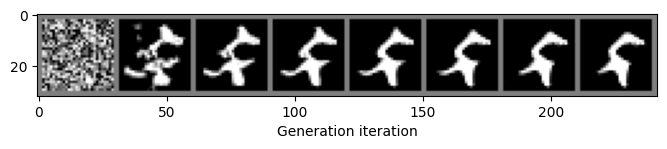

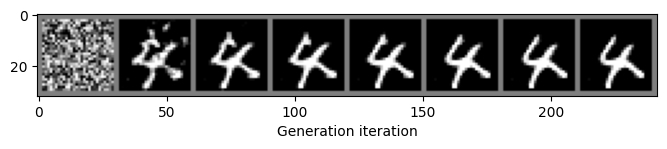

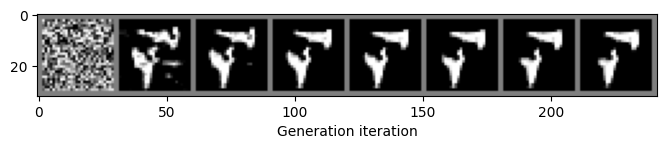

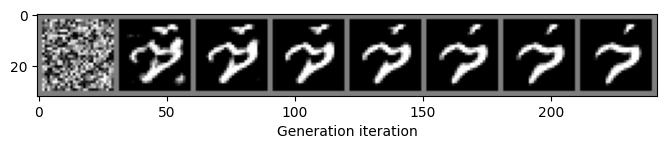

In [27]:
############ TODO #############:
images_per_step = generate_image(model, 4)
################################

for i in range(images_per_step.shape[1]):
    imgs_to_plot = images_per_step[0:256:32,i]
    grid = torchvision.utils.make_grid(imgs_to_plot, nrow=imgs_to_plot.shape[0], normalize=True, pad_value=0.5, padding=2)
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(8,8))
    plt.imshow(grid.clone().cpu())
    plt.xlabel("Generation iteration")
    plt.show()

# Evaluation (20 pts)

Now lets evaluate the model more precisely.

In [13]:
from scipy.spatial import distance
def compute_identifiability(orig_data, synth_data):
    """
    Args:
        orig_data: original data
        synth_data: synthetically generated data

    Returns:
        identifiability_value: Identifiability value
    """

    def compute_entropy(labels):
        """
        Compute entropy of the given labels.

        Args:
            labels: input labels

        Returns:
            entropy: computed entropy
        """
        unique, counts = np.unique(labels, return_counts=True)
        probabilities = counts / counts.sum()
        entropy = -np.sum(probabilities * np.log(probabilities + 1e-16))  # Add epsilon to avoid log(0)
        return entropy

    orig_data = np.asarray(orig_data)

    no, x_dim = np.shape(orig_data)

    W = np.zeros([x_dim,])

    # TODO: Compute weights using entropy of each dimension
    for i in range(x_dim):
        W[i] = compute_entropy(orig_data[:, i])

    W = W / np.sum(W)

    # Normalize original and synthetic data
    orig_data_hat = orig_data.copy()
    synth_data_hat = synth_data.copy()

    eps = 1e-16  # Small epsilon to avoid division by zero.
    print('beffff')
    # TODO: Normalize data using the weights
    for i in range(x_dim):
        std = np.std(orig_data[:, i]) + eps
        orig_data_hat[:, i] = W[i] * (orig_data[:, i] - np.mean(orig_data[:, i])) / std
        synth_data_hat[:, i] = W[i] * (synth_data[:, i] - np.mean(synth_data[:, i])) / std


    # TODO: Compute the distances to the two nearest neighbors for each data point in the original data.
    print('ba')
    orig_distances = distance.cdist(orig_data_hat, orig_data_hat, metric='euclidean')
    np.fill_diagonal(orig_distances, np.inf)  # Exclude self-distances
    nn1_orig_dist = np.min(orig_distances, axis=1)
    print('bb')
    nn2_orig_dist = np.partition(orig_distances, 1, axis=1)[:, 1]
    print('bc')
    # TODO: Compute the distances from each point in the original data to its nearest neighbor in the synthetic data.

    synth_distances = distance.cdist(orig_data_hat, synth_data_hat, metric='euclidean')
    print('bcc')
    nn_synth_dist = np.min(synth_distances, axis=1)
    print('bd')

    # TODO: Compute the identifiability metric
    '''
    Calculate the difference between the nearest synthetic neighbor distance and
    the second nearest original neighbor distance for each data point and
    count how many times this difference is negative.
    Compute the identifiability value as the fraction of times this occurs.
    '''
    identifiability_value = np.mean((nn_synth_dist - nn2_orig_dist) < 0)

    return identifiability_value

In [28]:
origin_data = []
i = 0
for img, _ in tqdm(test_loader):
    origin_data.append(img.numpy())
    i+=1
    if i == 3:
      break
# print('hhh')
origin_data = np.concatenate(origin_data, axis=0)

origin_data = origin_data.reshape(-1, 28*28)
# print('hhh')
synth_data = []
i = 0
for _ in tqdm(range(len(test_loader))):
    img = generate_image(model, BATCH_SIZE).squeeze().cpu().numpy()
    synth_data.append(img)
    i+=1
    if i == 3:
      break
print('aaa')
synth_data = np.concatenate(synth_data, axis=0)

synth_data = synth_data.reshape(-1, 28*28)



  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

aaa


In [29]:

identifiability_value = compute_identifiability(origin_data, synth_data)
print(identifiability_value)

beffff
ba
bb
bc
bcc
bd
0.22265625
